In [1]:
%load_ext autoreload

In [2]:
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 

In [3]:
import functools
from time import perf_counter
import kooplearn
import numpy as np
import matplotlib.pyplot as plt
import pnstyler.styler as styler
import ml_confs

In [4]:
configs = ml_confs.from_dict({
    'train_samples': 3000
})

In [5]:
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation

In [6]:
from kooplearn.datasets import Lorenz63

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples)
# Data rescaling
data = raw_data - np.mean(raw_data, axis=0)
data /= np.max(np.abs(data), axis=0)

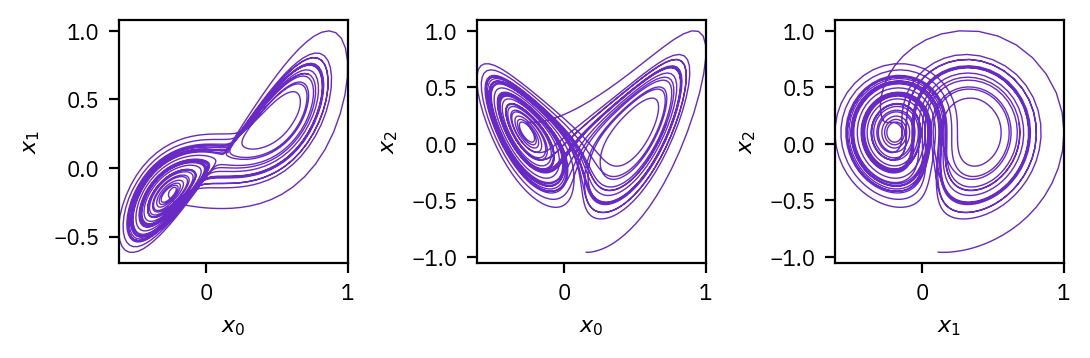

In [7]:
from itertools import combinations
fig, ax = plt.subplots(ncols=3, figsize = styler.figsize(width_to_height=3), layout='tight')
for i, (x, y) in enumerate(combinations(range(3), 2)):
    ax[i].plot(data[:, x], data[:, y], lw=0.5)
    ax[i].set_xlabel(f'$x_{x}$')
    ax[i].set_ylabel(f'$x_{y}$')

## Estimator fitting

In [16]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist
from kooplearn.models import KernelDMD
from kooplearn.models.nystroem_kernel import NystroemKernelLeastSquares
from kooplearn.data import traj_to_contexts

# Length scale of the kernel: median of the pairwise distances of the dataset
data_pdist = pdist(data)
kernel = RBF(length_scale=np.median(data_pdist))
train_data = traj_to_contexts(data)

ImportError: cannot import name 'LeastSquaresNystroem' from 'kooplearn.models.nystroem_kernel' (/Users/pietronovelli/code_repos/kooplearn/kooplearn/models/nystroem_kernel.py)

In [9]:
models_PCR = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=False, tikhonov_reg=1e-6, rank = 20, svd_solver='arnoldi'),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=False, svd_solver='randomized', tikhonov_reg=1e-6, rank = 20)
}

models_RRR = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=True, tikhonov_reg=1e-6, svd_solver='arnoldi', rank = 20),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=True, svd_solver='randomized', tikhonov_reg=1e-6, rank = 20, n_oversamples=10, rng_seed=0)
}

In [10]:
def runner(models):
    results = {}
    for name, model in models.items():
        print(f'Running {name}')
        model, fit_time = timer(model.fit)(train_data, verbose=False)
        results[name] = {
            'model': model,
            'fit_time': fit_time,
            'train_risk': model.risk()
        }
    return results

In [11]:
results = runner(models_RRR)

Running KernelDMD


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:69: RuntimeWarning: invalid value encountered in matmul
  norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X


Running RandSVDKernelDMD


In [12]:
# Print results:
for name, res in results.items():
    print(f'{name}:\n\tFit time: {res["fit_time"]:.2f}s\n\tTrain risk: {res["train_risk"]:.5e}')

KernelDMD:
	Fit time: 2.01s
	Train risk: 7.25100e-04
RandSVDKernelDMD:
	Fit time: 0.80s
	Train risk: 7.33596e-04


## Algorithms development:

## Nystroem PCR

## A better RRR

In [13]:
base_estimator = KernelDMD(kernel=kernel, reduced_rank=True, tikhonov_reg=1e-6, rank = 20, svd_solver='arnoldi')
base_estimator.fit(train_data)

Fitted KernelDMD model. Lookback length set to 1


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:69: RuntimeWarning: invalid value encountered in matmul
  norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X


In [14]:
def compare_fits(U_ref, V_ref, U_est, V_est):
    W_ref = U_ref @ V_ref.T
    W_est = U_est @ V_est.T
    return np.linalg.norm(W_ref - W_est, ord='fro') / np.linalg.norm(W_ref, ord='fro')

In [15]:
kernel_X = base_estimator.kernel_X
kernel_Y = base_estimator.kernel_Y
kernel_YX = base_estimator.kernel_YX

tikhonov_reg = 1e-3
rank = 20

In [16]:
from scipy.sparse.linalg import LinearOperator

In [ ]:
def fast_mv(x):
    

In [17]:
from kooplearn._src.operator_regression.dual import fit_reduced_rank_regression, regularize

In [59]:
from scipy.sparse import bsr_array, kron
from scipy.sparse.linalg import eigsh, aslinearoperator

def sym_rrr(
    K_X: np.ndarray,  # Kernel matrix of the input data
    K_Y: np.ndarray,  # Kernel matrix of the output data
    tikhonov_reg: float,  # Tikhonov regularization parameter, can be 0
    rank: int,  # Rank of the estimator
    svd_solver: str = "arnoldi",  # SVD solver to use. 'arnoldi' is faster but might be numerically unstable.
    _return_singular_values: bool = False
    # Whether to return the singular values of the projector. (Development purposes)
) -> tuple[np.ndarray, np.ndarray] or tuple[np.ndarray, np.ndarray, np.ndarray]:
    if tikhonov_reg == 0.0:
        raise NotImplementedError("Symmetric RRR without Tikhonov regularization is not implemented yet.")
    else:
        dim = K_X.shape[0]
        rsqrt_dim = dim ** (-0.5)
        # Rescaled Kernel matrices
        K_Xn = K_X * rsqrt_dim
        K_Yn = K_Y * rsqrt_dim

        def fast_Amv(x):
            dim = x.shape[0] // 2
            u = x[:dim]
            v = x[dim:]
            return np.r_[K_Xn @ (K_Yn @ v), K_Yn @ (K_Xn @ u)]

        def fast_Mmv(x):
            dim = x.shape[0] // 2
            u = x[:dim]
            v = x[dim:]
            reg_K = regularize(K_X, tikhonov_reg)
            return np.r_[reg_K @ v, reg_K @ u]

        A = LinearOperator((2 * dim, 2 * dim), matvec=fast_Amv)
        M = LinearOperator((2 * dim, 2 * dim), matvec=fast_Mmv)


        if svd_solver == "arnoldi":
            # Adding a small buffer to the Arnoldi-computed eigenvalues.
            _num_arnoldi_eigs = min(2*rank + 6, dim*2)
            sigma_sq, U = eigsh(A, k=_num_arnoldi_eigs, M=M)
        else:  # 'full'
            sigma_sq, U = eig(K, regularize(K_X, tikhonov_reg))

        max_imag_part = np.max(U.imag)
        if max_imag_part >= 10.0 * U.shape[0] * np.finfo(U.dtype).eps:
            logger.warning(
                "The computed projector is not real. The Kernel matrix is severely ill-conditioned."
            )
        U = np.real(U)
        # Post-process U. Promote numerical stability via additional QR decoposition if necessary.
        U = U[:, topk(sigma_sq.real, rank).indices]

        norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X
        U, _, columns_permutation = modified_QR(
            U, M=norm_inducing_op, column_pivoting=True
        )
        U = U[:, np.argsort(columns_permutation)]
        if U.shape[1] < rank:
            logger.warning(
                f"The numerical rank of the projector is smaller than the selected rank ({rank}). {rank - U.shape[1]} "
                f"degrees of freedom will be ignored."
            )
            _zeroes = np.zeros((U.shape[0], rank - U.shape[1]))
            U = np.c_[U, _zeroes]
            assert U.shape[1] == rank
        V = K_X @ np.asfortranarray(U)
        if _return_singular_values:
            return U, V, sigma_sq
        else:
            return U, V

In [22]:
from scipy.sparse import bmat, csr_array
from scipy.sparse.linalg import eigsh

In [19]:
K_X = base_estimator.kernel_X
K_Y = base_estimator.kernel_Y

dim = K_X.shape[0]
rsqrt_dim = dim ** (-0.5)
# Rescaled Kernel matrices
K_Xn = K_X * rsqrt_dim
K_Yn = K_Y * rsqrt_dim

K = K_Yn @ K_Xn
Kreg = regularize(K_X, tikhonov_reg)
# Adding a small buffer to the Arnoldi-computed eigenvalues.
# _num_arnoldi_eigs = min(2*rank + 6, dim*2)
# sigma_sq, U = eigsh(A, k=_num_arnoldi_eigs, M=M)

In [20]:
spK = csr_array(bmat([[None, K], [K.T, None]], format = 'csr'))
spKreg = csr_array(bmat([[None, Kreg], [Kreg, None]], format = 'csr'))

In [28]:
_num_arnoldi_eigs = min(6, dim*2)
sigma_sq, U = eigsh(spK, k=_num_arnoldi_eigs, M=spKreg, mode='buckling', sigma=100)

KeyboardInterrupt: 

In [24]:
sigma_sq

array([-43.28340139, -37.77323298, -35.28737111, -34.87946822,
        36.55874902,  42.06891736])

In [142]:
import matplotlib.pyplot as plt

In [143]:
plt.spy(spK)

Error in callback <function _draw_all_if_interactive at 0x28f01df80> (for post_execute):


KeyboardInterrupt: 

: 

In [15]:
np.ones((100, 5))*np.arange(5)

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1.